In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
train_loader, valid_loader, test_loader = mnist(valid=10000)

In [4]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Sigmoid()):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            layers.append(activation_fn())
            if dropout:
                layers.append(nn.Dropout())

        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
            
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [5]:
class autoencoder(nn.Module):
    def __init__(self, batchnorm = False, dropout = False, latent_size = 10):
        super(autoencoder, self).__init__()
        layers = []
        layers.append(nn.Conv2d(1, 16, 3, stride=1, padding=1))
        layers.append(nn.ReLU())
        if batchnorm:
            layers.append(nn.BatchNorm2d(16))
        layers.append(nn.MaxPool2d(2, stride=2))                        
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(nn.Conv2d(16, 32, 3, stride=1, padding=1))
        layers.append(nn.ReLU())
        if batchnorm:
            layers.append(nn.BatchNorm2d(32))
        layers.append(nn.MaxPool2d(2, stride=2, return_indices=False))                        
        if dropout:
            layers.append(nn.Dropout2d())                       
        
        self.encoder = nn.Sequential(*layers)
        
        
        self.fc1 = FullyConnected([32*7*7, latent_size], dropout=True)
        self.fc2 = FullyConnected([latent_size, 32*7*7], dropout=True, activation_fn=nn.ReLU())
      
        
        layersd = []
        layersd.append(nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1)) #32 14 14
        layersd.append(nn.ConvTranspose2d(16, 1, 4, stride=2, padding=0))
        layersd.append(nn.Tanh())
        
        self.decoder = nn.Sequential(*layersd)                        
        

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(-1, 32*7*7)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        data_rho = x.mean(0)
        x = self.fc2(x)
        x = torch.relu(x)
        x = x.view(50, 32, 7, 7)
        x = self.decoder(x)
        return x, data_rho


In [6]:
class Net(nn.Module):
    def __init__(self, latent_size = 10, batchnorm = False, dropout = False,  loss_fn = 
                 F.mse_loss, lr = 1e-4, l2 = 0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.batchnorm = batchnorm
        self.dropout = dropout
        self.ae = autoencoder(batchnorm, dropout, latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
    
 
    def forward(self, x):
        x, self.data_rho = self.ae(x)
        return x

    def rho_loss(self, rho, size_average=True):
        """
        D_KL(P||Q) = sum(p*log(p/q)) = -sum(p*log(q/p)) = -p*log(q/p) - (1-p)log((1-q)/(1-p))
        """
       # dkl = - torch.log(self.data_rho/rho) * rho - torch.log((1-self.data_rho)/(1-rho)) * (1-rho)
        dkl = min(- torch.log(self.data_rho) * rho - torch.log(1-self.data_rho) * (1-rho))
        if size_average:
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss = dkl.sum()
        return self._rho_loss
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        x = x.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss    

In [7]:
models = {'64,TT': Net(64, True, True), '64,TF': Net(64, True, False), '64,FT': Net(64, False, True), '64': Net(64)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [8]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        dataX = (data + 0.5*torch.randn(data.size())).clamp(0,1)
        for model in models.values():
            model.optim.zero_grad()
            output = model(dataX)
            rho_loss = model.rho_loss(rho)
            loss = model.loss(output, data) + rho_loss
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        print(line + losses)

In [9]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'rho_loss: {:.4f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    rho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            dataX = (data + 0.5*torch.randn(data.size())).clamp(0,1)
            output = {k: m(dataX) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction='sum').item() # sum up batch loss
                rho_loss[k] += m.rho_loss(rho, size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        rho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], rho_loss[k]))
    
    lines = '\n'.join([line(k, test_loss[k], rho_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [10]:
for epoch in range(1, 41):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 64,TT: 1.011524 64,TF: 1.017523 64,FT: 0.999010 64: 0.988210
Train Epoch: 1 [10000/50000 (20%)]	Losses 64,TT: 0.662369 64,TF: 0.663468 64,FT: 0.670587 64: 0.674342
Train Epoch: 1 [20000/50000 (40%)]	Losses 64,TT: 0.716522 64,TF: 0.688813 64,FT: 0.753200 64: 0.745613
Train Epoch: 1 [30000/50000 (60%)]	Losses 64,TT: 0.631686 64,TF: 0.598945 64,FT: 0.723178 64: 0.646814
Train Epoch: 1 [40000/50000 (80%)]	Losses 64,TT: 0.548064 64,TF: 0.510083 64,FT: 0.666920 64: 0.552471
Train Epoch: 1 [50000/50000 (100%)]	Losses 64,TT: 0.543654 64,TF: 0.500662 64,FT: 0.620502 64: 0.539923
Test set:
64,TT: loss: 0.5330	rho_loss: 0.0001
64,TF: loss: 0.5038	rho_loss: 0.0001
64,FT: loss: 0.6144	rho_loss: 0.0001
64: loss: 0.5426	rho_loss: 0.0001

Train Epoch: 2 [0/50000 (0%)]	Losses 64,TT: 0.538139 64,TF: 0.500305 64,FT: 0.610402 64: 0.539123
Train Epoch: 2 [10000/50000 (20%)]	Losses 64,TT: 0.534086 64,TF: 0.497252 64,FT: 0.590465 64: 0.529071
Train Epoch: 2 [20000/50000 (

Train Epoch: 11 [50000/50000 (100%)]	Losses 64,TT: 0.411255 64,TF: 0.394948 64,FT: 0.429142 64: 0.397657
Test set:
64,TT: loss: 0.3907	rho_loss: 0.0001
64,TF: loss: 0.3843	rho_loss: 0.0001
64,FT: loss: 0.4072	rho_loss: 0.0001
64: loss: 0.3863	rho_loss: 0.0001

Train Epoch: 12 [0/50000 (0%)]	Losses 64,TT: 0.414047 64,TF: 0.397391 64,FT: 0.428897 64: 0.399887
Train Epoch: 12 [10000/50000 (20%)]	Losses 64,TT: 0.377463 64,TF: 0.360324 64,FT: 0.390544 64: 0.363386
Train Epoch: 12 [20000/50000 (40%)]	Losses 64,TT: 0.353279 64,TF: 0.339751 64,FT: 0.366698 64: 0.340893
Train Epoch: 12 [30000/50000 (60%)]	Losses 64,TT: 0.402111 64,TF: 0.387665 64,FT: 0.416802 64: 0.388272
Train Epoch: 12 [40000/50000 (80%)]	Losses 64,TT: 0.370851 64,TF: 0.355185 64,FT: 0.383575 64: 0.356555
Train Epoch: 12 [50000/50000 (100%)]	Losses 64,TT: 0.412843 64,TF: 0.398462 64,FT: 0.428811 64: 0.399859
Test set:
64,TT: loss: 0.3886	rho_loss: 0.0001
64,TF: loss: 0.3825	rho_loss: 0.0001
64,FT: loss: 0.4040	rho_loss: 0.000

Train Epoch: 22 [20000/50000 (40%)]	Losses 64,TT: 0.371499 64,TF: 0.361680 64,FT: 0.382719 64: 0.360539
Train Epoch: 22 [30000/50000 (60%)]	Losses 64,TT: 0.395954 64,TF: 0.384948 64,FT: 0.404888 64: 0.382416
Train Epoch: 22 [40000/50000 (80%)]	Losses 64,TT: 0.387377 64,TF: 0.375436 64,FT: 0.398475 64: 0.373208
Train Epoch: 22 [50000/50000 (100%)]	Losses 64,TT: 0.394256 64,TF: 0.381234 64,FT: 0.404646 64: 0.379957
Test set:
64,TT: loss: 0.3756	rho_loss: 0.0001
64,TF: loss: 0.3733	rho_loss: 0.0001
64,FT: loss: 0.3865	rho_loss: 0.0001
64: loss: 0.3716	rho_loss: 0.0001

Train Epoch: 23 [0/50000 (0%)]	Losses 64,TT: 0.372811 64,TF: 0.357890 64,FT: 0.383571 64: 0.356949
Train Epoch: 23 [10000/50000 (20%)]	Losses 64,TT: 0.380902 64,TF: 0.367538 64,FT: 0.389277 64: 0.365100
Train Epoch: 23 [20000/50000 (40%)]	Losses 64,TT: 0.378096 64,TF: 0.367953 64,FT: 0.388596 64: 0.366144
Train Epoch: 23 [30000/50000 (60%)]	Losses 64,TT: 0.371767 64,TF: 0.361898 64,FT: 0.382667 64: 0.360307
Train Epoch: 23 

Train Epoch: 33 [0/50000 (0%)]	Losses 64,TT: 0.389811 64,TF: 0.381355 64,FT: 0.399134 64: 0.377932
Train Epoch: 33 [10000/50000 (20%)]	Losses 64,TT: 0.390749 64,TF: 0.379709 64,FT: 0.396362 64: 0.376663
Train Epoch: 33 [20000/50000 (40%)]	Losses 64,TT: 0.354526 64,TF: 0.346660 64,FT: 0.364695 64: 0.344128
Train Epoch: 33 [30000/50000 (60%)]	Losses 64,TT: 0.421062 64,TF: 0.412870 64,FT: 0.432493 64: 0.410174
Train Epoch: 33 [40000/50000 (80%)]	Losses 64,TT: 0.358642 64,TF: 0.349183 64,FT: 0.367884 64: 0.346120
Train Epoch: 33 [50000/50000 (100%)]	Losses 64,TT: 0.367614 64,TF: 0.358211 64,FT: 0.372407 64: 0.354654
Test set:
64,TT: loss: 0.3686	rho_loss: 0.0001
64,TF: loss: 0.3687	rho_loss: 0.0001
64,FT: loss: 0.3772	rho_loss: 0.0001
64: loss: 0.3653	rho_loss: 0.0001

Train Epoch: 34 [0/50000 (0%)]	Losses 64,TT: 0.370370 64,TF: 0.360719 64,FT: 0.377486 64: 0.356944
Train Epoch: 34 [10000/50000 (20%)]	Losses 64,TT: 0.374498 64,TF: 0.366715 64,FT: 0.383961 64: 0.362823
Train Epoch: 34 [2000

In [14]:
torch.save(models['64'].state_dict(), './conv_autoencoder.pth')

In [19]:
models = Net(64)
models.load_state_dict(torch.load('./conv_autoencoder.pth'))
models.eval()

Net(
  (ae): autoencoder(
    (encoder): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (fc1): FullyConnected(
      (model): Sequential(
        (0): Linear(in_features=1568, out_features=64, bias=True)
      )
    )
    (fc2): FullyConnected(
      (model): Sequential(
        (0): Linear(in_features=64, out_features=1568, bias=True)
      )
    )
    (decoder): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2))
      (2): Tanh()
    )
  )
)

In [22]:
data, _ = next(iter(test_loader))
output = models['64'](data + 0.5*torch.randn(data.size()).clamp(0,1))
output2 = models['64'](data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
to_plot2 = output2.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()

#decoded = models['plain'].decode(torch.eye(10))
#dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
#with torch.no_grad():
 #   encoded = models['plain'].E(data.view(-1, 28*28))
  #  print((encoded > 0.2).sum(1))
   # encoded[encoded < 0.2] = 0.
   # decoded_f = models['plain'].decode(encoded)
   # f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

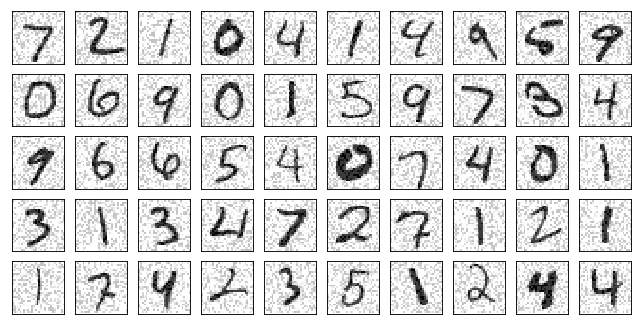

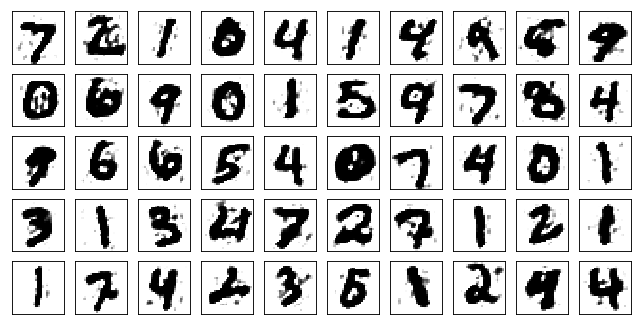

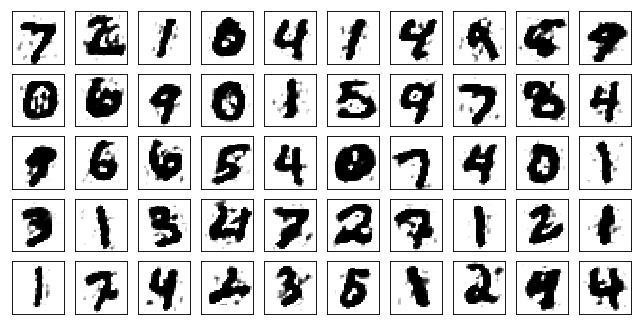

In [23]:
plot_mnist((data + torch.randn(data.size()).clamp(0,1)).data.numpy(), (5, 10))
plot_mnist(to_plot2, (5, 10))
plot_mnist(to_plot, (5, 10))
#plot_mnist(f_to_plot, (5, 10))
#plot_mnist(dec_to_plot, (8, 8))